In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Shopee/shopee-product-matching.zip' -d '/content/'

In [ ]:
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torchvision
import torch
from PIL import Image
from torchvision import  models
import pickle
import warnings
warnings.filterwarnings('ignore')

from transformers import logging
logging.set_verbosity_error()

In [5]:
# FUNCTIONS

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from scipy import sparse
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel


# RESNET50
class ResNet50Embedder():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet50(pretrained=True)
        self.model = self.model.to(self.device).eval()  # Move to device and set to evaluation mode
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def embed_image(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            features = self.model(image)

        return features.squeeze().cpu().numpy()

# INDO BERT UNCASED

class BERTIndEmbedder(nn.Module):

    def __init__(self, device='cpu'):
        super(BERTIndEmbedder, self).__init__()

        # reference: https://indolem.github.io/IndoBERT/
        self.model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

#         to freeze weights
        for param in self.model.parameters():
                param.requires_grad = False
        self.model.to(device)

    def transform(self, txt):
        # reference: https://indolem.github.io/IndoBERT/
        tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
        encoded_input  = tokenizer.encode_plus( txt,
                                                truncation=True,
                                                max_length=128,
                                                add_special_tokens=True,
                                                padding=True,
                                                return_tensors='pt').values()
        return encoded_input

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, txt):
        # inputs_ids, token_type_ids, attention_mask = self.transform(txt)
        # inputs_ids, token_type_ids, attention_mask = inputs_ids.to('cuda'), \
        #                                         token_type_ids.to('cuda'), attention_mask.to('cuda')

        inputs_ids, token_type_ids, attention_mask = self.transform(txt)
        inputs_ids, token_type_ids, attention_mask = inputs_ids, \
                                                token_type_ids, attention_mask
        with torch.no_grad():
            encoded_layers = self.model(inputs_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids)
        features = self.mean_pooling(encoded_layers, attention_mask)
        return features


# BERT UNCASED

class BERTEmbedder2(nn.Module):

    def __init__(self, device='cpu'):
        super(BERTEmbedder2, self).__init__()
        self.bert_path = "/content/drive/MyDrive/Shopee/sentence-transformer"
        self.model = BertModel.from_pretrained(self.bert_path)

#         to freeze weights
        for param in self.model.parameters():
                param.requires_grad = False
        self.model.to(device)

    def transform(self, txt):
        tokenizer = BertTokenizer.from_pretrained(self.bert_path)
        encoded_input  = tokenizer.encode_plus( txt,
                                                truncation=True,
                                                max_length=128,
                                                add_special_tokens=True,
                                                padding=True,
                                                return_tensors='pt').values()
        return encoded_input

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, txt):
        inputs_ids, token_type_ids, attention_mask = self.transform(txt)
        inputs_ids, token_type_ids, attention_mask = inputs_ids, \
                                                token_type_ids, attention_mask
        # inputs_ids, token_type_ids, attention_mask = self.transform(txt)
        # inputs_ids, token_type_ids, attention_mask = inputs_ids.to('cuda'), \
        #                                         token_type_ids.to('cuda'), attention_mask.to('cuda')
        with torch.no_grad():
            encoded_layers = self.model(inputs_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids)
        features = self.mean_pooling(encoded_layers, attention_mask)
        return features


# TF-IDF
tfidf_model = TfidfVectorizer(decode_error="replace",vocabulary=pickle.load(open("/content/drive/MyDrive/Shopee/tfidf_model.pkl", "rb")))
text_embeddings = sparse.load_npz("/content/drive/MyDrive/Shopee/text_embeddings.npz")


def vectorize_txt(txt):
  ind_model_txt.eval()
  with torch.no_grad():
      output = ind_model_txt(txt).cpu().numpy()
  return output

In [6]:
with open('/content/drive/MyDrive/Shopee/7_tfidf_final_v3.pkl', 'rb') as f:
    train_df = pickle.load(f)

In [7]:
data_test = pd.read_csv('test_v2.csv')
data_test.head()

,posting_id,image,image_phash,title
0,1,mop_1.jpg,xxxx,ALAT PEL LANTAI SPIN MOP
1,2,mop_2.jpg,xxxx,alat pel murah spin mop - hitam
2,3,mop_3.jpg,xxxx,spin mop 360 / alat pel lantai
3,4,mop_4.jpg,xxxx,SPIN MOP MURAH / SPIN MOP PROCLEAN / PRO CLEAN...
4,5,Bimoli.jpg,xxxx,BIMOLI KLASIK MINYAK GORENG 2L POUCH X 6


In [12]:
def func(ResNet50Embedder, BERTIndEmbedder, BERTEmbedder2, text_embeddings, train_df, data):
  model_img = ResNet50Embedder()
  vectors = train_df.resnet50_v

  data['resnet_50_vector'] = data['image'].apply(lambda img_path: model_img.embed_image('/content/test_images/'+ img_path))

  image_uploaded = Image.open('/content/test_images/'+ data['image'].values[0])
  print('UPLOADED IMAGE:\n')
  plt.figure(figsize = (3, 3))
  plt.imshow(image_uploaded)
  plt.axis('off')
  plt.title(data['title'].values[0])
  plt.show()

  resnet_50_vector = np.stack(data.resnet_50_vector)
  resnet_50_vector = torch.Tensor(resnet_50_vector)
  resnet_50_vector = F.normalize(resnet_50_vector)

  vectors = np.stack(vectors)
  vectors = torch.Tensor(vectors)
  vectors = F.normalize(vectors)

  cts = torch.matmul( resnet_50_vector, vectors.T).T
  cts = cts.cpu().numpy()

  del vectors, resnet_50_vector

  IDX = np.where(cts > 0.93)[0]
  data['preds_resnet'] = [[x for x in train_df.posting_id[IDX]] for x in data.index]
  # print('RESNET50', [[x for x in train_df.posting_id[IDX]] for x in data.index])
  # obtain image names
  img_names = [x for x in train_df.image[IDX]]
  img_titles = [x for x in train_df.title[IDX]]
  print('\n-----------------------------------------------------------\n')
  print('\nRESNET50: MATCHED IMAGES:\n')
  if len(IDX) == 0: print('No Matches predicted')
  for i, x in enumerate(img_names):
    plt.figure(figsize = (9, 3 * int(np.ceil(len(IDX)/3))))
    plt.subplot(int(np.ceil(len(IDX)/3)), 3, i+1)
    image_uploaded = Image.open('/content/train_images/'+ x)
    plt.imshow(image_uploaded)
    plt.axis('off')
    plt.title(img_titles[i])
    plt.show()



  ind_model_txt = BERTIndEmbedder('cpu')

  def vectorize_txt(txt):
    ind_model_txt.eval()
    with torch.no_grad():
        output = ind_model_txt(txt).cpu().numpy()
    return output

  data['indo_bert_v'] = data['title'].apply(lambda x: vectorize_txt(x))

  indo_bert_v = np.stack(data.indo_bert_v.values[0])
  indo_bert_v = torch.Tensor(indo_bert_v)
  indo_bert_v = F.normalize(indo_bert_v)

  vectors1 = np.stack(train_df.ind_sbert_v).squeeze(1)
  vectors1 = torch.Tensor(vectors1)
  vectors1 = F.normalize(vectors1)

  cts_indo_bert = torch.matmul( indo_bert_v, vectors1.T).T
  cts_indo_bert = cts_indo_bert.cpu().numpy()
  IDX_indo_bert = np.where(cts_indo_bert > 0.88)[0]

  del vectors1, indo_bert_v, cts_indo_bert

  data['preds_indoBERTbaseP2'] = [[x for x in train_df.posting_id[IDX_indo_bert]] for x in data.index]
  # print('INDO BERT UNCASED', [[x for x in train_df.posting_id[IDX_indo_bert]] for x in data.index])

  # obtain image names
  img_names = [x for x in train_df.image[IDX_indo_bert]]
  img_titles = [x for x in train_df.title[IDX_indo_bert]]
  print('\n-----------------------------------------------------------\n')
  print('\nINDO BERT UNCASED: MATCHED IMAGES:\n')
  if len(IDX_indo_bert) == 0: print('No Matches predicted')
  for i, x in enumerate(img_names):
    plt.figure(figsize = (9, 3 * int(np.ceil(len(IDX_indo_bert)/3))))
    plt.subplot(int(np.ceil(len(IDX_indo_bert)/3)), 3, i+1)
    image_uploaded = Image.open('/content/train_images/'+ x)
    plt.imshow(image_uploaded)
    plt.axis('off')
    plt.title(img_titles[i])
    plt.show()

  model_txt_en = BERTEmbedder2('cpu')

  def vectorize_txt_en(txt):
      model_txt_en.eval()
      with torch.no_grad():
          output = model_txt_en(txt).cpu().numpy()
      return output

  data['bert_v'] = data['title'].apply(lambda x: vectorize_txt_en(x))

  bert_v = np.stack(data.bert_v.values[0])
  bert_v = torch.Tensor(bert_v)
  bert_v = F.normalize(bert_v)

  vectors2 = np.stack(train_df.sbert_v).squeeze(1)
  vectors2 = torch.Tensor(vectors2)
  vectors2 = F.normalize(vectors2)

  cts_bert = torch.matmul( bert_v, vectors2.T).T
  cts_bert = cts_bert.cpu().numpy()
  IDX_bert = np.where(cts_bert > 0.92)[0]

  del vectors2, bert_v, cts_bert

  data['preds_sbert'] = [[x for x in train_df.posting_id[IDX_bert]] for x in data.index]
  # print('BERT UNCASED', [[x for x in train_df.posting_id[IDX_bert]] for x in data.index])

  # obtain image names
  img_names = [x for x in train_df.image[IDX_bert]]
  img_titles = [x for x in train_df.title[IDX_bert]]
  print('\n-----------------------------------------------------------\n')
  print('\nBERT UNCASED: MATCHED IMAGES:\n')
  if len(IDX_bert) == 0: print('No Matches predicted')
  for i, x in enumerate(img_names):
    plt.figure(figsize = (9, 3 * int(np.ceil(len(IDX_bert)/3))))
    plt.subplot(int(np.ceil(len(IDX_bert)/3)), 3, i+1)
    image_uploaded = Image.open('/content/train_images/'+ x)
    plt.imshow(image_uploaded)
    plt.axis('off')
    plt.title(img_titles[i])
    plt.show()

  def concat():
      def cat(row):
          comm = np.concatenate([row.resnet50_v, row.ind_sbert_v.squeeze(), row.sbert_v.squeeze()])
          return comm
      return cat

  def concat_test():
      def cat(row):
          comm = np.concatenate([row.resnet_50_vector, row.indo_bert_v.squeeze(), row.bert_v.squeeze()])
          return comm
      return cat

  train_df['concat_v'] = train_df.apply(concat(), axis=1)
  vectors3 = np.stack(train_df['concat_v'])

  concat_v = data.apply(concat_test(), axis=1)
  concat_v = np.stack(concat_v)

  KNN = 50
  model = NearestNeighbors(n_neighbors=KNN)
  model.fit(vectors3)
  distances, indices = model.kneighbors(concat_v)

  del vectors3, model, concat_v

  IDX_concat = np.where(distances[0]<37.0)
  IDS_concat = indices[0][IDX_concat]
  data['preds_concat'] = [[x for x in train_df.iloc[IDS_concat].posting_id] for x in data.index]
  # print('CONCAT:', [[x for x in train_df.iloc[IDS_concat].posting_id] for x in data.index])

  # obtain image names
  img_names = [x for x in train_df.image[IDS_concat]]
  img_titles = [x for x in train_df.title[IDS_concat]]
  print('\n-----------------------------------------------------------\n')
  print('\nCONCATENATION OF RESNET, INDO BERT and BERT: MATCHED IMAGES:\n')
  if len(IDS_concat) == 0: print('No Matches predicted')
  for i, x in enumerate(img_names):
    plt.figure(figsize = (9, 3 * int(np.ceil(len(IDS_concat)/3))))
    plt.subplot(int(np.ceil(len(IDS_concat)/3)), 3, i+1)
    image_uploaded = Image.open('/content/train_images/'+ x)
    plt.imshow(image_uploaded)
    plt.axis('off')
    plt.title(img_titles[i])
    plt.show()

  tfidf_model = TfidfVectorizer(decode_error="replace",vocabulary=pickle.load(open("/content/drive/MyDrive/Shopee/tfidf_model.pkl", "rb")))
  tfidf_v = tfidf_model.fit_transform(data.title)

  del tfidf_model

  cts_tfidf = text_embeddings.dot(tfidf_v.T).T.toarray()
  IDX_tfidf = np.where(cts_tfidf[0] > 0.53)
  data['preds_tfidf'] = [[x for x in train_df.iloc[IDX_tfidf].posting_id] for x in data.index]
  # print('TF-IDF', [[x for x in train_df.iloc[IDX_tfidf].posting_id] for x in data.index])

  # obtain image names
  img_names = [x for x in train_df.image.iloc[IDX_tfidf]]
  img_titles = [x for x in train_df.title.iloc[IDX_tfidf]]
  print('\n-----------------------------------------------------------\n')
  print('\nTF-IDF: MATCHED IMAGES:\n')
  if len(IDX_tfidf[0]) == 0: print('No Matches predicted')

  for i, x in enumerate(img_names):
    plt.figure(figsize = (9, 3 * int(np.ceil(len(IDX_tfidf[0])/3))))
    plt.subplot(int(np.ceil(len(IDX_tfidf[0])/3)), 3, i+1)
    image_uploaded = Image.open('/content/train_images/'+ x)
    plt.imshow(image_uploaded)
    plt.axis('off')
    plt.title(img_titles[i])
  plt.show()

  def combine_for_sub(row):
      x = np.concatenate([row.preds_concat, row.preds_phash, row.preds_tfidf])
      return ' '.join( np.unique(x) )

  def combine_for_test(row):
      x = np.concatenate([row.preds_concat, row.preds_tfidf])
      return ' '.join( np.unique(x) )

  x = np.concatenate([pd.Series(data['preds_concat'].values[0]), [], pd.Series(data['preds_tfidf'].values[0])])
  final = np.unique(x) # array
  print('\n-----------------------------------------------------------\n')
  print('FINAL RESULTS OF MATCHED IMAGES:\n')
  if len(final) == 0: print('No Matches predicted')
  # obtain image names
  for id in final:
    img_nm = train_df.image[train_df[train_df['posting_id'] == id].index].values[0]
    img_title = train_df.title[train_df[train_df['posting_id'] == id].index].values[0]
    plt.figure(figsize = (3, 3))
    image_uploaded = Image.open('/content/train_images/'+ img_nm)
    plt.imshow(image_uploaded)
    plt.axis('off')
    plt.title(img_title)
    plt.show()

# TEST RESULTS

In [13]:
data_test = pd.read_csv('test_v2.csv')
data_test.head()

,posting_id,image,image_phash,title
0,1,mop_1.jpg,xxxx,ALAT PEL LANTAI SPIN MOP
1,2,mop_2.jpg,xxxx,alat pel murah spin mop - hitam
2,3,mop_3.jpg,xxxx,spin mop 360 / alat pel lantai
3,4,mop_4.jpg,xxxx,SPIN MOP MURAH / SPIN MOP PROCLEAN / PRO CLEAN...
4,5,Bimoli.jpg,xxxx,BIMOLI KLASIK MINYAK GORENG 2L POUCH X 6


UPLOADED IMAGE:



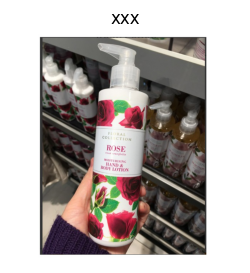


-----------------------------------------------------------


RESNET50: MATCHED IMAGES:

No Matches predicted

-----------------------------------------------------------


INDO BERT UNCASED: MATCHED IMAGES:

No Matches predicted

-----------------------------------------------------------


BERT UNCASED: MATCHED IMAGES:

No Matches predicted

-----------------------------------------------------------


CONCATENATION OF RESNET, INDO BERT and BERT: MATCHED IMAGES:

No Matches predicted

-----------------------------------------------------------


TF-IDF: MATCHED IMAGES:

No Matches predicted

-----------------------------------------------------------

FINAL RESULTS OF MATCHED IMAGES:

No Matches predicted


In [22]:
data = data_test.loc[[13]]
result = func(ResNet50Embedder, BERTIndEmbedder, BERTEmbedder2, text_embeddings, train_df, data)

In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

class ResNet50Embedder():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet50(pretrained=True)
        self.model = self.model.to(self.device).eval()  # Move to device and set to evaluation mode
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def embed_image(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            features = self.model(image)

        return features.squeeze().cpu().numpy()

In [5]:
# class ResNetEmbedder(nn.Module):

#     def __init__(self, device='cpu'):
#         super(ResNetEmbedder, self).__init__()
#         self.model = models.resnet50(pretrained=True)
#         self.device = device
#         # path = '/content/drive/MyDrive/Shopee/resnet50-19c8e357.pth'
#         self.model.load_state_dict(torch.load(path))
# #         to freeze weights
#         for param in self.model.parameters():
#                 param.requires_grad = False
#         self.model.to(device)

# # reference: https://pytorch.org/vision/stable/transforms.html
#     def transform(self, img):
#         transform = torchvision.transforms.Compose([
#             torchvision.transforms.Resize(512),
#             torchvision.transforms.CenterCrop(224),
#             torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]
#             )
#         ])
#         return transform(img)

#     def forward(self, img):
#         img_tr = self.transform(img).unsqueeze(0)
#         img_tr = img_tr.to(self.device)
#         features = self.model(img_tr).squeeze()
#         return features

In [5]:
# import torch
# import torchvision.models as models
# import torchvision.transforms as transforms
# from PIL import Image

# class ResNet50Embedder:
#     def __init__(self):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.model = models.resnet50(pretrained=True).to(self.device)
#         self.model.eval()
#         self.transform = transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])

#     def embed_image(self, image_path):
#         image = Image.open(image_path).convert('RGB')
#         image = self.transform(image).unsqueeze(0).to(self.device)

#         with torch.no_grad():
#             features = self.model(image)

#         return features.squeeze().cpu()

In [7]:
model_img = ResNet50Embedder()
# def vectorize_img(img_path):
#     img = Image.open(img_path).convert('RGB')
#     model_img.eval()
#     with torch.no_grad():
#         output = model_img(img).cpu().numpy()
#     return output

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


In [8]:
# class ResNetEmbedder(nn.Module):

#     def __init__(self, device='cpu'):
#         super(ResNetEmbedder, self).__init__()
#         self.model = models.resnet50(pretrained=False)
#         self.device = device
#         path = '/content/drive/MyDrive/Shopee/resnet50-19c8e357.pth'
#         self.model.load_state_dict(torch.load(path))
# #         to freeze weights
#         for param in self.model.parameters():
#                 param.requires_grad = False
#         self.model.to(device)

# # reference: https://pytorch.org/vision/stable/transforms.html
#     def transform(self, img):
#         transform = torchvision.transforms.Compose([
#             torchvision.transforms.Resize(512),
#             torchvision.transforms.CenterCrop(224),
#             torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]
#             )
#         ])
#         return transform(img)

#     def forward(self, img):
#         img_tr = self.transform(img).unsqueeze(0)
#         img_tr = img_tr.to(self.device)
#         features = self.model(img_tr).squeeze()
#         return features

In [9]:
# model_img = ResNetEmbedder('cuda' if torch.cuda.is_available() else 'cpu')
# def vectorize_img(img_path):
#     img = Image.open(img_path).convert('RGB')
#     model_img.eval()
#     with torch.no_grad():
#         output = model_img(img).cpu().numpy()
#     return output

In [8]:
# import pickle

# with open('/content/drive/MyDrive/Shopee/7_tfidf_final_v2.pkl', 'rb') as f:
#     train_df = pickle.load(f)

In [9]:
# import pickle

# with open('/content/drive/MyDrive/Shopee/rough.pkl', 'rb') as f:
#     train_df_resnet = pickle.load(f)

In [14]:
# train_df.resnet50_v = train_df_resnet.resnet50_v
# train_df.preds_resnet = train_df_resnet.preds_resnet
# train_df.f1_resnet = train_df_resnet.f1_resnet
# train_df.precision_resnet = train_df_resnet.precision_resnet
# train_df.recall_resnet = train_df_resnet.recall_resnet

In [16]:
# train_df.to_pickle('7_tfidf_final_v3.pkl')

In [ ]:
# %%time
# train_df['resnet50_v'] = train_df['image'].progress_apply(lambda img_path: model_img.embed_image(path + 'train_images/' + img_path))

In [8]:
# data = train_df[['posting_id', 'image', 'image_phash', 'title']].loc[[0]]

In [132]:
# train_to_validate = train_df.loc[[30621]]
train_to_validate = train_df.loc[[1971]]

In [133]:
train_to_validate

,posting_id,image,image_phash,title,label_group,target,resnet50_v,preds_resnet,oof,f1,...,recall_concat,preds_phash,preds_tfidf,f1_tfidf,precision_tfidf,recall_tfidf,matches,f1_final,precision_final,recall_final
1971,train_1562723480,0f385bdac68a8f1bac5ebbf2d1a2bb26.jpg,b934c6ce9ea1983c,Smart watch T80 waterproof bracelet watch Fit...,3374933356,"[train_1562723480, train_1010625996]","[-2.5425687, 0.2776151, -3.6940508, -3.698147,...",[train_1562723480],[train_1562723480],0.666667,...,0.5,[train_1562723480],[train_1562723480],0.666667,1.0,0.5,[train_1562723480],0.666667,1.0,0.5


In [134]:
train_to_validate.columns

Index(['posting_id', 'image', 'image_phash', 'title', 'label_group', 'target',
       'resnet50_v', 'preds_resnet', 'oof', 'f1', 'precision', 'recall',
       'f1_resnet', 'precision_resnet', 'recall_resnet', 'ind_sbert_v',
       'preds_indoBERTbaseP2', 'sbert_v', 'preds_sbert', 'f1_sbert',
       'precision_sbert', 'recall_sbert', 'concat_v', 'preds_concat',
       'f1_concat', 'precision_concat', 'recall_concat', 'preds_phash',
       'preds_tfidf', 'f1_tfidf', 'precision_tfidf', 'recall_tfidf', 'matches',
       'f1_final', 'precision_final', 'recall_final'],
      dtype='object')

In [135]:
# data.head()

In [174]:
data = pd.read_csv('test_v2.csv')
data.head()

,posting_id,image,image_phash,title
0,1,mop_1.jpg,xxxxxxxxxxxxx,xx
1,2,mop_2.jpg,xxxxxxxxxxxxx,xx
2,3,mop_3.jpg,xxxxxxxxxxxxx,xx
3,4,mop_4.jpg,xxxxxxxxxxxxx,xx
4,5,watch1.jpg,xxxxxxxxxxxxx,xx


In [175]:
data = data.loc[[7]]

In [176]:
data

,posting_id,image,image_phash,title
7,8,watch4.jpg,xxxxxxxxxxxxx,xx


In [177]:
# data.preds_resnet.values[0]

In [178]:
vectors = train_df.resnet50_v

In [179]:
vectors

0        [-2.1922166, 0.7773978, -1.108614, -2.5192137,...
1        [-1.034856, 0.2791248, -1.2548816, -1.3825614,...
2        [-1.4920533, 1.6365535, -4.9461446, -5.341603,...
3        [-3.3702533, -0.7792417, -1.6157548, -3.642001...
4        [-0.8642448, -0.5364889, -2.5898497, -1.380294...
                               ...                        
34245    [-1.672246, -0.03072636, -0.7509407, 1.1461804...
34246    [-2.8293164, -0.09250227, -1.9903986, -3.07886...
34247    [-1.748291, -1.6386198, 0.341978, -0.8806981, ...
34248    [0.16756342, 1.360392, -1.521109, -2.4740274, ...
34249    [-1.0102272, -2.0205235, -2.128541, -1.6373509...
Name: resnet50_v, Length: 34250, dtype: object

In [180]:
path = '/content/'
# data['resnet_50_vector'] = data['image'].apply(lambda img_path: vectorize_img(path + 'train_images/' + img_path))

# path = '/content/'
data['resnet_50_vector'] = data['image'].apply(lambda img_path: model_img.embed_image(path + 'test_images/'+ img_path))

In [181]:
data['resnet_50_vector']

7    [-2.4264514, -1.1067599, -3.5683124, -3.888264...
Name: resnet_50_vector, dtype: object

In [182]:
data['resnet_50_vector'].values[0].shape

(1000,)

In [183]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([train_to_validate.resnet50_v.values[0]], [data.resnet_50_vector.values[0]])

array([[0.88173854]], dtype=float32)

In [184]:
# normalize vectors
import torch.nn.functional as F

resnet_50_vector = np.stack(data.resnet_50_vector)
resnet_50_vector = torch.Tensor(resnet_50_vector) #.to('cuda')
resnet_50_vector = F.normalize(resnet_50_vector)

vectors = np.stack(vectors)
vectors = torch.Tensor(vectors) #.to('cuda')
vectors = F.normalize(vectors)
# vectors1 = vectors / np.linalg.norm(vectors)

In [124]:
cts = torch.matmul( resnet_50_vector, vectors.T).T
cts = cts.cpu().numpy()

In [125]:
cts

array([[0.29132727],
       [0.37440208],
       [0.41467083],
       ...,
       [0.49391884],
       [0.41647303],
       [0.34438342]], dtype=float32)

In [126]:
IDX = np.where(cts > 0.93)[0]

In [127]:
IDX

array([30621])

In [128]:
train_df.posting_id[IDX].values

array(['train_1347656677'], dtype=object)

In [129]:
# train_to_validate.preds_resnet.values

In [130]:
# [x for x in train_df.posting_id[IDX]]

In [131]:
data['preds_resnet'] = [[x for x in train_df.posting_id[IDX]] for x in data.index]
# data['preds_resnet'] = [pd.Series([x for x in train_df.posting_id[IDX].values])]

In [50]:
train_to_validate.preds_resnet

30621    [train_1347656677]
Name: preds_resnet, dtype: object

In [51]:
data.head()

,posting_id,image,image_phash,title,resnet_50_vector,preds_resnet
2,3,mop_3.jpg,xxxxxxxxxxxxx,xx,"[-2.0975885, -1.1888644, 0.7897488, -1.6150753...","[train_2406723712, train_1347656677]"


In [52]:
pd.Series(data.preds_resnet.values[0])

0    train_2406723712
1    train_1347656677
dtype: object

## Bert Indo

In [53]:
from transformers import AutoTokenizer, AutoModel

class BERTIndEmbedder(nn.Module):

    def __init__(self, device='cpu'):
        super(BERTIndEmbedder, self).__init__()

        # reference: https://indolem.github.io/IndoBERT/
        self.model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

#         to freeze weights
        for param in self.model.parameters():
                param.requires_grad = False
        self.model.to(device)

    def transform(self, txt):
        # reference: https://indolem.github.io/IndoBERT/
        tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
        encoded_input  = tokenizer.encode_plus( txt,
                                                truncation=True,
                                                max_length=128,
                                                add_special_tokens=True,
                                                padding=True,
                                                return_tensors='pt').values()
        return encoded_input

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, txt):
        # inputs_ids, token_type_ids, attention_mask = self.transform(txt)
        # inputs_ids, token_type_ids, attention_mask = inputs_ids.to('cuda'), \
        #                                         token_type_ids.to('cuda'), attention_mask.to('cuda')

        inputs_ids, token_type_ids, attention_mask = self.transform(txt)
        inputs_ids, token_type_ids, attention_mask = inputs_ids, \
                                                token_type_ids, attention_mask
        with torch.no_grad():
            encoded_layers = self.model(inputs_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids)
        features = self.mean_pooling(encoded_layers, attention_mask)
        return features

In [54]:
ind_model_txt = BERTIndEmbedder('cpu')

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
def vectorize_txt(txt):
  ind_model_txt.eval()
  with torch.no_grad():
      output = ind_model_txt(txt).cpu().numpy()
  return output

In [56]:
data['indo_bert_v'] = data['title'].apply(lambda x: vectorize_txt(x))

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([train_to_validate.ind_sbert_v.values[0][0]], [data.indo_bert_v.values[0][0]])

array([[0.37884572]], dtype=float32)

In [58]:
indo_bert_v = np.stack(data.indo_bert_v.values[0])
indo_bert_v = torch.Tensor(indo_bert_v) #.to('cuda')
indo_bert_v = F.normalize(indo_bert_v)

vectors1 = np.stack(train_df.ind_sbert_v).squeeze(1)
vectors1 = torch.Tensor(vectors1) #.to('cuda')
vectors1 = F.normalize(vectors1)

In [59]:
cts_indo_bert = torch.matmul( indo_bert_v, vectors1.T).T
cts_indo_bert = cts_indo_bert.cpu().numpy()

In [60]:
IDX_indo_bert = np.where(cts_indo_bert > 0.88)[0]
train_df.posting_id[IDX_indo_bert].values

array([], dtype=object)

In [61]:
data['preds_indoBERTbaseP2'] = [[x for x in train_df.posting_id[IDX_indo_bert]] for x in data.index]
# data['preds_indoBERTbaseP2'] = train_df.posting_id[IDX_indo_bert]

In [62]:
IDX_indo_bert

array([], dtype=int64)

In [63]:
train_to_validate.preds_indoBERTbaseP2.values

array([array(['train_1347656677'], dtype=object)], dtype=object)

In [64]:
# go ahead with normal BERT

from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel

class BERTEmbedder2(nn.Module):

    def __init__(self, device='cpu'):
        super(BERTEmbedder2, self).__init__()
        self.bert_path = "/content/drive/MyDrive/Shopee/sentence-transformer"
        self.model = BertModel.from_pretrained(self.bert_path)

#         to freeze weights
        for param in self.model.parameters():
                param.requires_grad = False
        self.model.to(device)

    def transform(self, txt):
        tokenizer = BertTokenizer.from_pretrained(self.bert_path)
        encoded_input  = tokenizer.encode_plus( txt,
                                                truncation=True,
                                                max_length=128,
                                                add_special_tokens=True,
                                                padding=True,
                                                return_tensors='pt').values()
        return encoded_input

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, txt):
        inputs_ids, token_type_ids, attention_mask = self.transform(txt)
        inputs_ids, token_type_ids, attention_mask = inputs_ids, \
                                                token_type_ids, attention_mask
        # inputs_ids, token_type_ids, attention_mask = self.transform(txt)
        # inputs_ids, token_type_ids, attention_mask = inputs_ids.to('cuda'), \
        #                                         token_type_ids.to('cuda'), attention_mask.to('cuda')
        with torch.no_grad():
            encoded_layers = self.model(inputs_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids)
        features = self.mean_pooling(encoded_layers, attention_mask)
        return features

In [65]:
model_txt_en = BERTEmbedder2('cpu')

In [66]:
def vectorize_txt_en(txt):
    model_txt_en.eval()
    with torch.no_grad():
        output = model_txt_en(txt).cpu().numpy()
    return output

In [67]:
data['bert_v'] = data['title'].apply(lambda x: vectorize_txt_en(x))

In [68]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([train_to_validate.sbert_v.values[0][0]], [data.bert_v.values[0][0]])

array([[0.36290926]], dtype=float32)

In [69]:
bert_v = np.stack(data.bert_v.values[0])
bert_v = torch.Tensor(bert_v) #.to('cuda')
bert_v = F.normalize(bert_v)

vectors2 = np.stack(train_df.sbert_v).squeeze(1)
vectors2 = torch.Tensor(vectors2) #.to('cuda')
vectors2 = F.normalize(vectors2)

In [70]:
cts_bert = torch.matmul( bert_v, vectors2.T).T
cts_bert = cts_bert.cpu().numpy()

In [71]:
IDX_bert = np.where(cts_bert > 0.92)[0]
train_df.posting_id[IDX_bert].values

array([], dtype=object)

In [72]:
data['preds_sbert'] = [[x for x in train_df.posting_id[IDX_bert]] for x in data.index]
# data['preds_sbert'] = train_df.posting_id[IDX_bert]

In [73]:
train_to_validate.preds_sbert.values

array([array(['train_1347656677'], dtype=object)], dtype=object)

In [74]:
data.columns

Index(['posting_id', 'image', 'image_phash', 'title', 'resnet_50_vector',
       'preds_resnet', 'indo_bert_v', 'preds_indoBERTbaseP2', 'bert_v',
       'preds_sbert'],
      dtype='object')

In [75]:
train_to_validate.columns

Index(['posting_id', 'image', 'image_phash', 'title', 'label_group', 'target',
       'resnet50_v', 'preds_resnet', 'oof', 'f1', 'precision', 'recall',
       'f1_resnet', 'precision_resnet', 'recall_resnet', 'ind_sbert_v',
       'preds_indoBERTbaseP2', 'sbert_v', 'preds_sbert', 'f1_sbert',
       'precision_sbert', 'recall_sbert', 'concat_v', 'preds_concat',
       'f1_concat', 'precision_concat', 'recall_concat', 'preds_phash',
       'preds_tfidf', 'f1_tfidf', 'precision_tfidf', 'recall_tfidf', 'matches',
       'f1_final', 'precision_final', 'recall_final'],
      dtype='object')

In [76]:
def concat():
    def cat(row):
        comm = np.concatenate([row.resnet50_v, row.ind_sbert_v.squeeze(), row.sbert_v.squeeze()])
        return comm
    return cat

def concat_test():
    def cat(row):
        comm = np.concatenate([row.resnet_50_vector, row.indo_bert_v.squeeze(), row.bert_v.squeeze()])
        return comm
    return cat

In [77]:
train_df['concat_v'] = train_df.apply(concat(), axis=1)

In [78]:
vectors = np.stack(train_df['concat_v'])

In [79]:
concat_v = data.apply(concat_test(), axis=1)
concat_v = np.stack(concat_v)

In [80]:
from sklearn.neighbors import NearestNeighbors
KNN = 50
model = NearestNeighbors(n_neighbors=KNN)
model.fit(vectors)

NearestNeighbors(n_neighbors=50)

In [81]:
concat_v.shape

(1, 2536)

In [82]:
concat_v

array([[-2.0975885 , -1.1888644 ,  0.7897488 , ..., -0.22852153,
         0.5371143 ,  0.23678958]], dtype=float32)

In [83]:
distances, indices = model.kneighbors(concat_v)

In [84]:
IDX_concat = np.where(distances[0]<37.0)

In [85]:
IDX_concat

(array([], dtype=int64),)

In [86]:
IDS_concat = indices[0][IDX_concat]

In [87]:
train_df.iloc[IDS_concat].posting_id.values

array([], dtype=object)

In [88]:
data['preds_concat'] = [[x for x in train_df.iloc[IDS_concat].posting_id] for x in data.index]
# data['preds_concat'] = train_df.iloc[IDS_concat].posting_id

In [89]:
train_to_validate.preds_concat.values

array([array(['train_1347656677'], dtype=object)], dtype=object)

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(decode_error="replace",vocabulary=pickle.load(open("/content/drive/MyDrive/Shopee/tfidf_model.pkl", "rb")))
tfidf_v = tfidf_model.fit_transform(data.title)

In [91]:
tfidf_v

<1x24939 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [92]:
# text_embeddings = np.load('/content/drive/MyDrive/Shopee/text_embedding.npz')

In [93]:
from scipy import sparse

# sparse.save_npz("text_embeddings.npz", text_embeddings)
text_embeddings = sparse.load_npz("/content/drive/MyDrive/Shopee/text_embeddings.npz")

In [94]:
text_embeddings

<34250x24939 sparse matrix of type '<class 'numpy.float64'>'
	with 276757 stored elements in Compressed Sparse Row format>

In [95]:
# text_embeddings = tfidf_model.fit_transform(train_df.title)

In [96]:
cts_tfidf = text_embeddings.dot(tfidf_v.T).T.toarray()

In [97]:
cts_tfidf

array([[0., 0., 0., ..., 0., 0., 0.]])

In [98]:
IDX_tfidf = np.where(cts_tfidf[0]>0.53)

In [99]:
IDX_tfidf

(array([], dtype=int64),)

In [100]:
train_df.iloc[IDX_tfidf].posting_id.values

array([], dtype=object)

In [101]:
data['preds_tfidf'] = [[x for x in train_df.iloc[IDX_tfidf].posting_id] for x in data.index]
# data['preds_tfidf'] = train_df.iloc[IDX_tfidf].posting_id

In [102]:
train_to_validate.preds_tfidf.values

array([array(['train_2406723712', 'train_1347656677'], dtype=object)],
      dtype=object)

In [103]:
def combine_for_sub(row):
    x = np.concatenate([row.preds_concat, row.preds_phash, row.preds_tfidf])
    return ' '.join( np.unique(x) )

def combine_for_test(row):
    x = np.concatenate([row.preds_concat, row.preds_tfidf])
    return ' '.join( np.unique(x) )

In [104]:
combine_for_sub(train_to_validate.iloc[0])

'train_1347656677 train_2406723712'

In [105]:
data.preds_tfidf

2    []
Name: preds_tfidf, dtype: object

In [106]:
data.preds_concat

2    []
Name: preds_concat, dtype: object

In [107]:
pd.Series(data['preds_concat'].values[0])

Series([], dtype: float64)

In [108]:
x = np.concatenate([pd.Series(data['preds_concat'].values[0]), [], pd.Series(data['preds_tfidf'].values[0])])
np.unique(x)

array([], dtype=float64)

In [109]:
data

,posting_id,image,image_phash,title,resnet_50_vector,preds_resnet,indo_bert_v,preds_indoBERTbaseP2,bert_v,preds_sbert,preds_concat,preds_tfidf
2,3,mop_3.jpg,xxxxxxxxxxxxx,xx,"[-2.0975885, -1.1888644, 0.7897488, -1.6150753...","[train_2406723712, train_1347656677]","[[1.7841545, 0.5775601, -1.4836894, 0.63722014...",[],"[[-0.12079937, -0.22128455, 0.62884253, 0.2773...",[],[],[]


In [111]:
final_matches = data.apply(combine_for_test, axis=1)

In [112]:
final_matches.values

array([''], dtype=object)